###**Importing Initial Libraries**

In [3]:
!pip install catboost

In [ ]:
!pip install ydata-profiling

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 19.2 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=085b9374ead799d1c179b954ce0f7529b0a0a9341bfe527f475c8b8b73d4d96d
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [4]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

# Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
#from pandas_profiling import ProfileReport

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.cluster import KMeans




<Figure size 1000x750 with 0 Axes>

###**First look at the data**

In [5]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

In [6]:
ss= pd.read_csv("/content/submission.csv")

In [ ]:
ss.head(5)

,country,lat,lon,population,taux_ensoleillement,demande_energetique_actuelle,capacite_installee_actuelle,duree_ensoleillement_annuel,cout_installation_solaire,proximite_infrastructures_energetiques,taux_adoption_energies_renouvelables,stabilite_politique,taux_acces_energie,niveau_urbanisation,potentiel_investissement,types_sols,emissions_co2_evitees,idh,habit_de_mariage,nombre_animaux_domestiques
0,Sierra Leone,8.4606,-11.7799,7976983,6.016310,2288.205830,1506.365949,3856.453895,1453.281847,56.433841,25.196118,9.187338,35.022992,58.938006,2,sablonneux,9432.861305,0.722109,traditionnel,3
1,Sierra Leone,8.4606,-11.7799,7976983,6.410925,2402.680846,1878.297944,3652.332264,1076.560589,46.100498,27.037202,5.307233,52.154399,58.293952,4,argileux,7466.567405,0.518997,traditionnel,3
2,South Sudan,6.8769,31.3069,11193725,4.642565,3996.471566,344.400305,3810.507756,980.596863,88.583926,47.880078,1.462924,79.302572,24.914731,2,sablonneux,1239.535797,0.785365,moderne,9
3,Mozambique,-18.6657,35.5296,31255435,5.704522,3134.406856,1614.664206,3319.984749,1373.043279,45.876645,40.282065,5.420247,47.551657,35.089942,3,sablonneux,7052.913351,0.400865,traditionnel,9
4,Zimbabwe,-19.0154,29.1549,14862924,6.581508,2560.551232,1151.776893,2829.581194,895.661665,91.039562,10.630429,3.527300,75.120867,46.989207,5,rocheux,9744.951246,0.516602,traditionnel,6


In [ ]:
print(f'\nSubmission contains {ss.shape[0]} samples and {ss.shape[1]} variables')


Submission contains 25000 samples and 20 variables


In [ ]:
train.head(5)


,country,lat,lon,population,taux_ensoleillement,demande_energetique_actuelle,demande_energetique_projectee,capacite_installee_actuelle,duree_ensoleillement_annuel,cout_installation_solaire,...,taux_adoption_energies_renouvelables,stabilite_politique,taux_acces_energie,niveau_urbanisation,potentiel_investissement,types_sols,emissions_co2_evitees,idh,habit_de_mariage,nombre_animaux_domestiques
0,Zimbabwe,-19.0154,29.1549,14862924,5.004870,485.085906,544.232257,583.128945,3936.978948,926.985577,...,14.282752,2.575677,67.501053,35.733884,4,rocheux,555.209808,0.441787,traditionnel,2
1,Congo (Brazzaville),-0.2280,15.8277,5518092,4.609972,1422.802172,1864.048290,163.908475,3753.749894,862.739803,...,41.408913,2.747196,61.851008,40.134654,2,sablonneux,3722.310275,0.380139,traditionnel,5
2,Namibia,-22.9576,18.4904,2540905,5.792826,4711.082367,5525.433108,1404.435659,3804.854034,1298.932535,...,41.259170,3.091990,17.384882,46.964564,5,argileux,9824.421047,0.678362,moderne,0
3,Somalia,5.1521,46.1996,15893222,4.104030,799.426659,1447.543617,1370.179083,2047.305693,1256.611785,...,21.930857,3.639728,21.744383,40.211287,1,rocheux,9407.183123,0.731126,moderne,7
4,Congo (Kinshasa),-4.0383,21.7587,89561403,6.103335,2526.920477,3029.604497,962.398626,3421.335117,1484.398731,...,37.127657,6.572047,47.679339,63.201230,3,argileux,9184.154421,0.357112,moderne,2


In [ ]:
test.head(3)

,country,lat,lon,population,taux_ensoleillement,demande_energetique_actuelle,demande_energetique_projectee,capacite_installee_actuelle,duree_ensoleillement_annuel,cout_installation_solaire,...,taux_adoption_energies_renouvelables,stabilite_politique,taux_acces_energie,niveau_urbanisation,potentiel_investissement,types_sols,emissions_co2_evitees,idh,habit_de_mariage,nombre_animaux_domestiques
0,Guinea,9.9456,-9.6966,13132795,4.127216,1742.542776,2157.259405,1021.851235,3835.946683,872.520272,...,NaN,7.379525,76.425479,35.358111,5,rocheux,4048.488123,0.328018,moderne,7
1,Mauritania,21.0079,-10.9408,4649658,5.008540,255.495071,428.684740,1617.543567,2739.032034,1096.259730,...,49.593022,1.084977,57.176834,49.970568,4,argileux,6999.991146,0.400916,traditionnel,5
2,South Africa,-30.5595,22.9375,59308690,6.976930,3768.494240,5678.901223,946.143038,2011.915469,938.680998,...,10.298804,6.788885,78.470385,61.007593,5,argileux,6697.363318,0.397704,moderne,1


In [10]:
#Singling out the target column
TARGET_COL = "demande_energetique_projectee"

Target Distribution

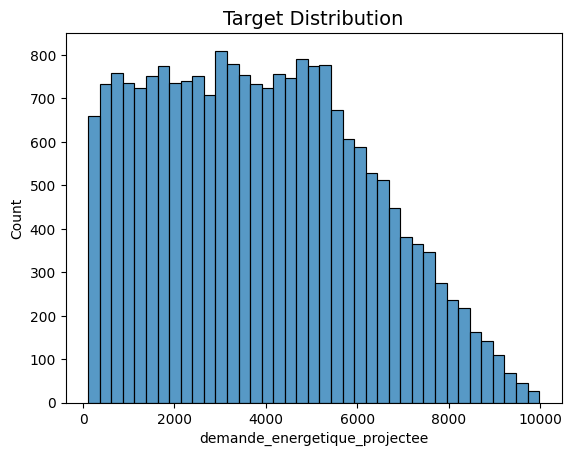

In [ ]:
_= sns.histplot(train[TARGET_COL])
_= plt.title("Target Distribution", fontsize=14)

The dataset shows some imbalance, this fact will affect the validation strategy that we will perform later


We will then use ydata-profiling to have a better understanding of our dataset.
We'll first install the library and then execute it.

In [ ]:
profile = ProfileReport(train, title="Pandas Profiling Report")
profile.to_notebook_iframe()

Summary of missing values

In [7]:
train.isna().sum()

,0
country,0
lat,0
lon,0
population,0
taux_ensoleillement,0
demande_energetique_actuelle,0
demande_energetique_projectee,0
capacite_installee_actuelle,0
duree_ensoleillement_annuel,0
cout_installation_solaire,0


### **Univariate analysis of the categorical data**

We separate the categorical columns from the rest of the dataset to perform some descriptive analysis

In [8]:
cat_cols = ['potentiel_investissement',
 'types_sols',
 'habit_de_mariage']

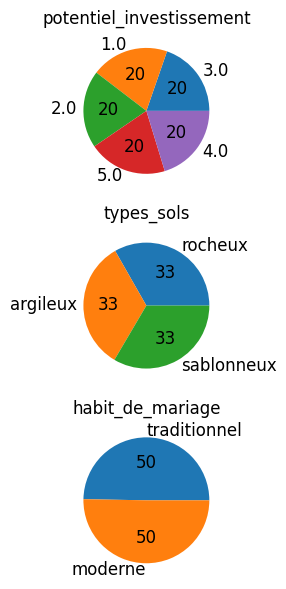

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(18, 6))

for i, c in enumerate(train[cat_cols]):
    _ = train[c].value_counts()[::-1].plot(kind = 'pie', ax=axes[i], title=c, autopct='%.0f', fontsize=12)
    _ = axes[i].set_ylabel('')

_ = plt.tight_layout()

This distribution seems to suggest that the categorical features have been randomly generated.
The feature "country" has too many unique categories to be analyzed with a pie chart.

### **Univariate analysis of the numerical data**

We had the country feature to the list of categorical data and create a list of numerical features. We also remove the target column from the list of features.

In [11]:
cat_cols_with_country = ['country', 'potentiel_investissement',
 'types_sols',
 'habit_de_mariage']

features= [c for c in train.columns if c not in TARGET_COL]

num_cols = [c for c in features if c not in cat_cols_with_country]
num_cols

['lat',
 'lon',
 'population',
 'taux_ensoleillement',
 'demande_energetique_actuelle',
 'capacite_installee_actuelle',
 'duree_ensoleillement_annuel',
 'cout_installation_solaire',
 'proximite_infrastructures_energetiques',
 'taux_adoption_energies_renouvelables',
 'stabilite_politique',
 'taux_acces_energie',
 'niveau_urbanisation',
 'emissions_co2_evitees',
 'idh',
 'nombre_animaux_domestiques']

In [ ]:
#features_no_geo_data = [c for c in train.columns if c not in ['country', 'lat', 'lon']]

#num_cols = [c for c in features_no_geo_data if c not in cat_cols]
#num_cols

The next step in the exploratory process is to perform some univatiate analysis of the numerical variables

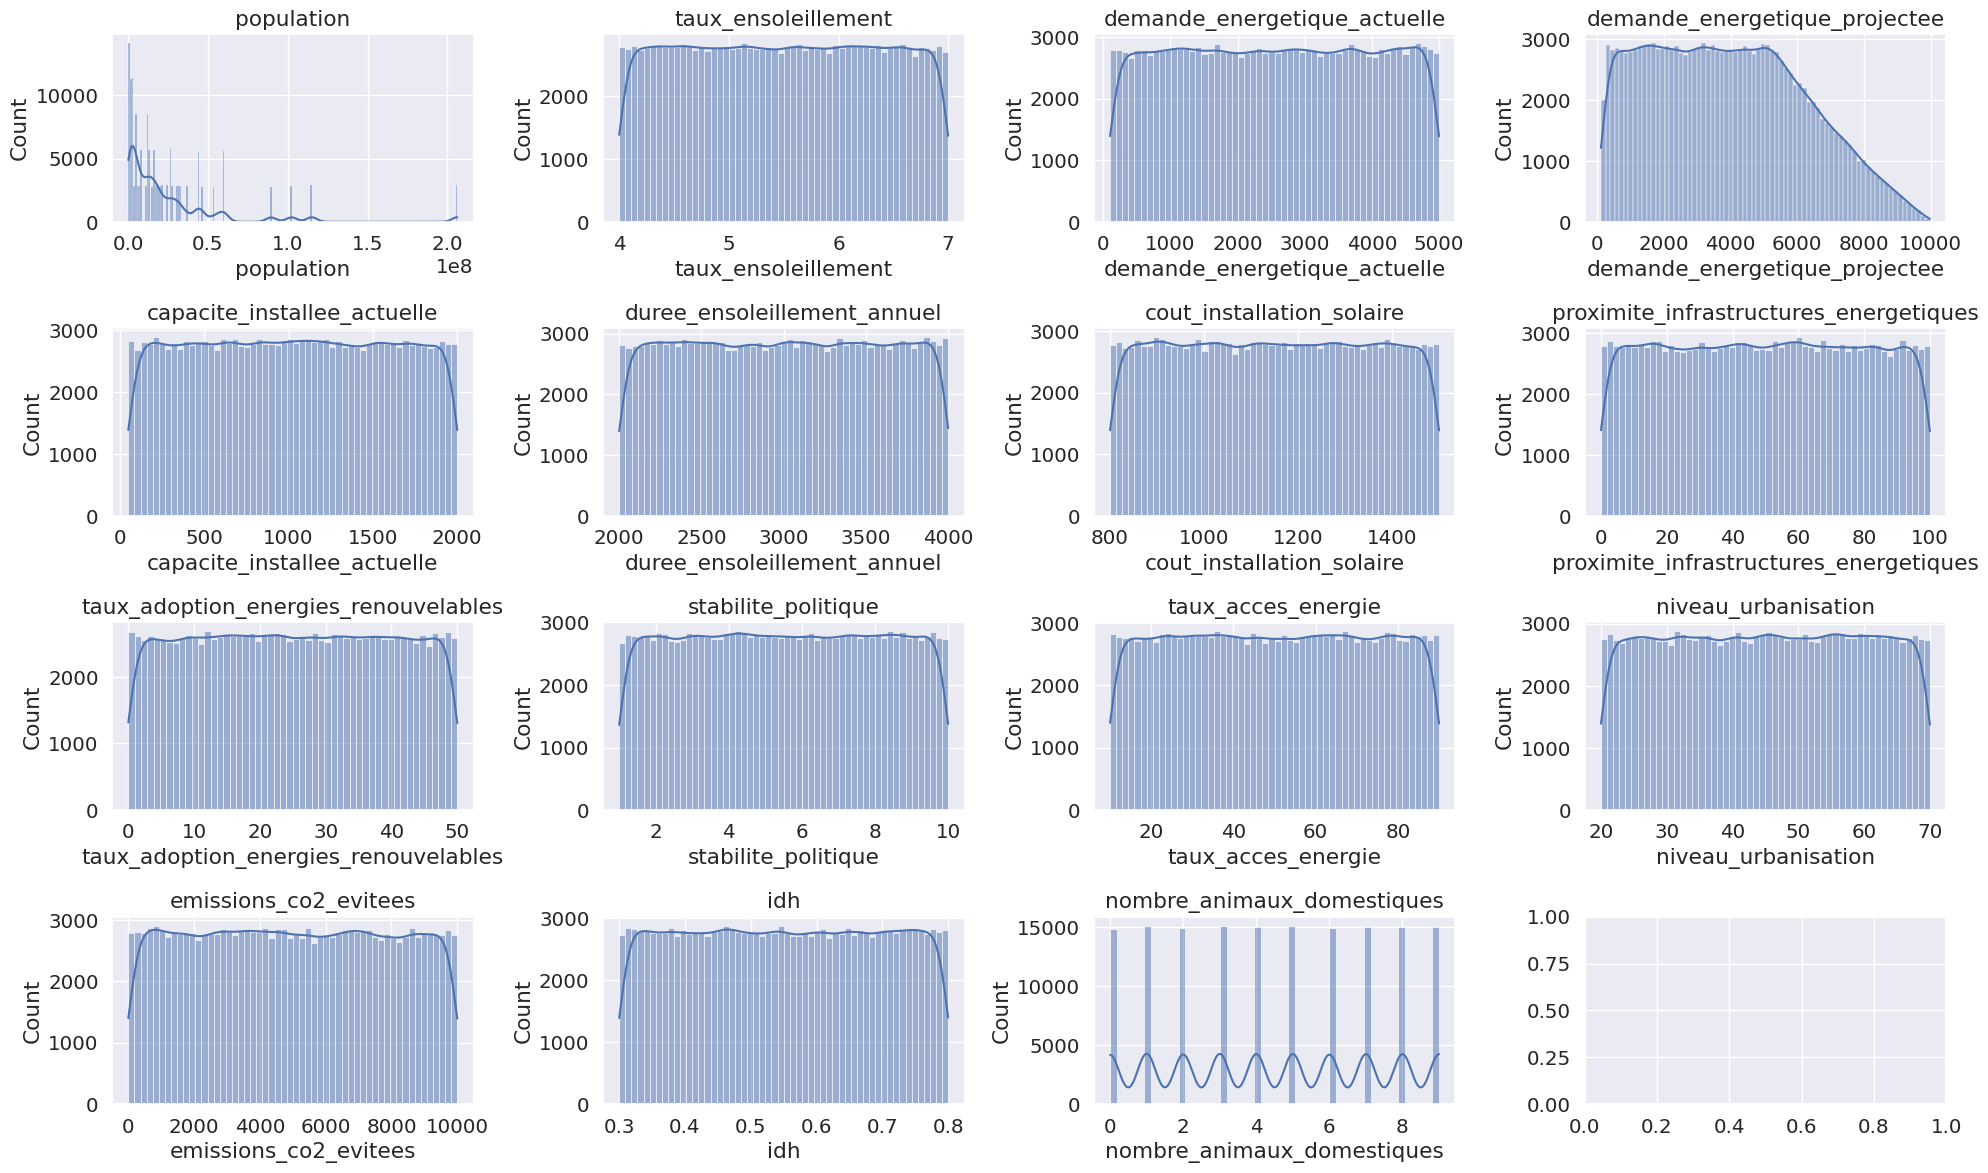

In [ ]:
fig, axes = plt.subplots(4, 4, figsize= (20, 12))
axes = axes.flatten()

# Plot each variable
for i, predictor in enumerate(num_cols):
    sns.histplot(train[predictor], kde=True, ax=axes[i])
    axes[i].set_title(predictor)

# Adjust layout
plt.tight_layout()
plt.show()

The visuals show that most of the features are uniformly distributed (except the population feature that is skewed to the right).

In [ ]:
skewness = {col: train[col].skew() for col in num_cols}

#printing the skewness
for predictor, skewness in skewness.items():
  print(f"The skewness of the {predictor} is: {skewness}")

The skewness of the population is: 3.030020143763858
The skewness of the taux_ensoleillement is: 0.0012632611946477345
The skewness of the demande_energetique_actuelle is: -0.001899725052501375
The skewness of the demande_energetique_projectee is: 0.28670000839099974
The skewness of the capacite_installee_actuelle is: 0.0014673371424254779
The skewness of the duree_ensoleillement_annuel is: 0.000589168170418782
The skewness of the cout_installation_solaire is: 0.002351314894902123
The skewness of the proximite_infrastructures_energetiques is: 0.001182477466169715
The skewness of the taux_adoption_energies_renouvelables is: 0.00028652237628755064
The skewness of the stabilite_politique is: -0.00110179040474665
The skewness of the taux_acces_energie is: 0.0004906203304032717
The skewness of the niveau_urbanisation is: -0.005638112298484937
The skewness of the emissions_co2_evitees is: 0.007704972855387016
The skewness of the idh is: 0.0001517028851464112
The skewness of the nombre_animau

 near zero skewness (skewness within -0.5 and 0.5 range)
 moderate skewness (skewness between -0.5 and -1 or 0.5 and 1)
  high skewness (skewness less than -1 or greater than 1)

### **Univariate analysis - Box plots**

The box-plots are a very effective way to show identify outliers in the data.

,0
lat,"Axes(0.125,0.712609;0.168478x0.167391)"
lon,"Axes(0.327174,0.712609;0.168478x0.167391)"
population,"Axes(0.529348,0.712609;0.168478x0.167391)"
taux_ensoleillement,"Axes(0.731522,0.712609;0.168478x0.167391)"
demande_energetique_actuelle,"Axes(0.125,0.511739;0.168478x0.167391)"
capacite_installee_actuelle,"Axes(0.327174,0.511739;0.168478x0.167391)"
duree_ensoleillement_annuel,"Axes(0.529348,0.511739;0.168478x0.167391)"
cout_installation_solaire,"Axes(0.731522,0.511739;0.168478x0.167391)"
proximite_infrastructures_energetiques,"Axes(0.125,0.31087;0.168478x0.167391)"
taux_adoption_energies_renouvelables,"Axes(0.327174,0.31087;0.168478x0.167391)"


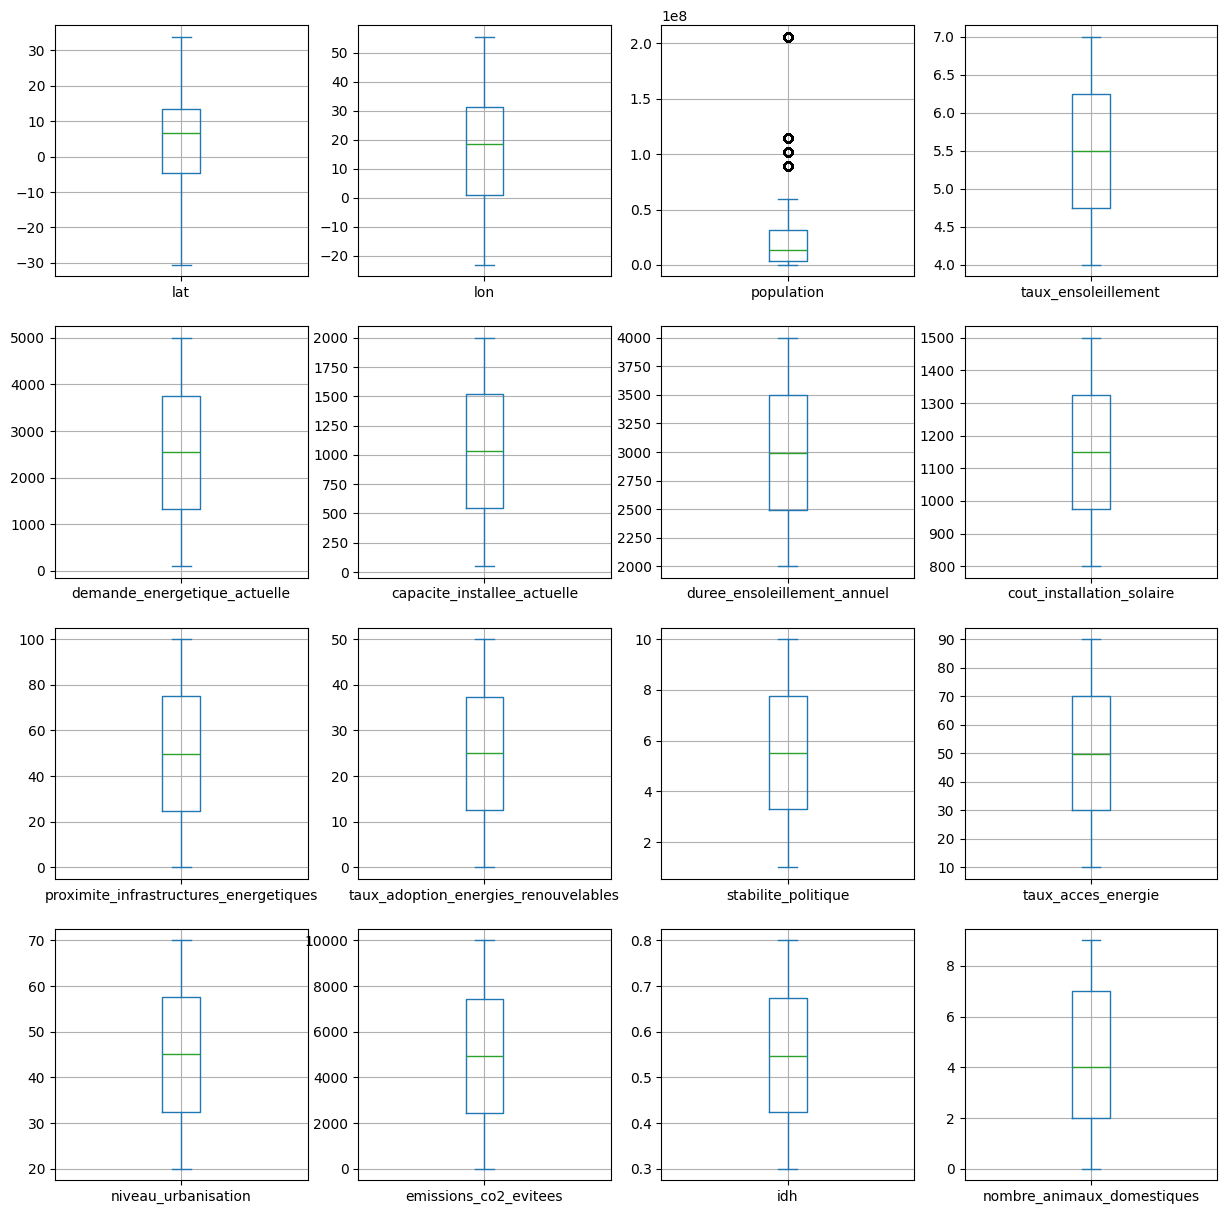

In [ ]:
train[num_cols].plot(kind="box", subplots=True, layout=(4,4), figsize=(15,15))

Most features have no outliers except for the population variable.

## **Bivariate analysis of the numerical features**

In [ ]:
sns.pairplot(train[num_cols])
plt.suptitle('Pair plots between classes', y=1.02)
plt.show()

Aside from the latitude and longitude, there seems to be no correlation between the features.

## **Baseline Models**

**1. Concating/Joining train and test datasets.**


In [ ]:
train.shape, test.shape

((150000, 21), (62500, 21))

In [12]:
df = pd.concat([train, test], axis=0).reset_index(drop = True)
df.shape

(212500, 21)

In [ ]:
df.head()

,country,lat,lon,population,taux_ensoleillement,demande_energetique_actuelle,demande_energetique_projectee,capacite_installee_actuelle,duree_ensoleillement_annuel,cout_installation_solaire,...,taux_adoption_energies_renouvelables,stabilite_politique,taux_acces_energie,niveau_urbanisation,potentiel_investissement,types_sols,emissions_co2_evitees,idh,habit_de_mariage,nombre_animaux_domestiques
0,Zimbabwe,-19.0154,29.1549,14862924,5.004870,485.085906,544.232257,583.128945,3936.978948,926.985577,...,14.282752,2.575677,67.501053,35.733884,4,rocheux,555.209808,0.441787,traditionnel,2
1,Congo (Brazzaville),-0.2280,15.8277,5518092,4.609972,1422.802172,1864.048290,163.908475,3753.749894,862.739803,...,41.408913,2.747196,61.851008,40.134654,2,sablonneux,3722.310275,0.380139,traditionnel,5
2,Namibia,-22.9576,18.4904,2540905,5.792826,4711.082367,5525.433108,1404.435659,3804.854034,1298.932535,...,41.259170,3.091990,17.384882,46.964564,5,argileux,9824.421047,0.678362,moderne,0
3,Somalia,5.1521,46.1996,15893222,4.104030,799.426659,1447.543617,1370.179083,2047.305693,1256.611785,...,21.930857,3.639728,21.744383,40.211287,1,rocheux,9407.183123,0.731126,moderne,7
4,Congo (Kinshasa),-4.0383,21.7587,89561403,6.103335,2526.920477,3029.604497,962.398626,3421.335117,1484.398731,...,37.127657,6.572047,47.679339,63.201230,3,argileux,9184.154421,0.357112,moderne,2


**2. Encoding categorical columns.**

We will apply various types of encoding on categorical features due to the high number of unique categories. We'll want to avoid high dimensionality

In [13]:
# Label Encoding
le = LabelEncoder()
df['habit_de_mariage'] = le.fit_transform(df['habit_de_mariage'])

In [14]:
df.head()

,country,lat,lon,population,taux_ensoleillement,demande_energetique_actuelle,demande_energetique_projectee,capacite_installee_actuelle,duree_ensoleillement_annuel,cout_installation_solaire,...,taux_adoption_energies_renouvelables,stabilite_politique,taux_acces_energie,niveau_urbanisation,potentiel_investissement,types_sols,emissions_co2_evitees,idh,habit_de_mariage,nombre_animaux_domestiques
0,Zimbabwe,-19.0154,29.1549,14862924,5.004870,485.085906,544.232257,583.128945,3936.978948,926.985577,...,14.282752,2.575677,67.501053,35.733884,4,rocheux,555.209808,0.441787,1,2
1,Congo (Brazzaville),-0.2280,15.8277,5518092,4.609972,1422.802172,1864.048290,163.908475,3753.749894,862.739803,...,41.408913,2.747196,61.851008,40.134654,2,sablonneux,3722.310275,0.380139,1,5
2,Namibia,-22.9576,18.4904,2540905,5.792826,4711.082367,5525.433108,1404.435659,3804.854034,1298.932535,...,41.259170,3.091990,17.384882,46.964564,5,argileux,9824.421047,0.678362,0,0
3,Somalia,5.1521,46.1996,15893222,4.104030,799.426659,1447.543617,1370.179083,2047.305693,1256.611785,...,21.930857,3.639728,21.744383,40.211287,1,rocheux,9407.183123,0.731126,0,7
4,Congo (Kinshasa),-4.0383,21.7587,89561403,6.103335,2526.920477,3029.604497,962.398626,3421.335117,1484.398731,...,37.127657,6.572047,47.679339,63.201230,3,argileux,9184.154421,0.357112,0,2


In [15]:
#We'll use one-hot-encoding on the "types_sols" and "potentiel_investissement" columns
one_hot_cols = ['types_sols', 'potentiel_investissement']
df = pd.get_dummies(df, columns = one_hot_cols)

In [16]:
df.head(5)

,country,lat,lon,population,taux_ensoleillement,demande_energetique_actuelle,demande_energetique_projectee,capacite_installee_actuelle,duree_ensoleillement_annuel,cout_installation_solaire,...,habit_de_mariage,nombre_animaux_domestiques,types_sols_argileux,types_sols_rocheux,types_sols_sablonneux,potentiel_investissement_1,potentiel_investissement_2,potentiel_investissement_3,potentiel_investissement_4,potentiel_investissement_5
0,Zimbabwe,-19.0154,29.1549,14862924,5.004870,485.085906,544.232257,583.128945,3936.978948,926.985577,...,1,2,False,True,False,False,False,False,True,False
1,Congo (Brazzaville),-0.2280,15.8277,5518092,4.609972,1422.802172,1864.048290,163.908475,3753.749894,862.739803,...,1,5,False,False,True,False,True,False,False,False
2,Namibia,-22.9576,18.4904,2540905,5.792826,4711.082367,5525.433108,1404.435659,3804.854034,1298.932535,...,0,0,True,False,False,False,False,False,False,True
3,Somalia,5.1521,46.1996,15893222,4.104030,799.426659,1447.543617,1370.179083,2047.305693,1256.611785,...,0,7,False,True,False,True,False,False,False,False
4,Congo (Kinshasa),-4.0383,21.7587,89561403,6.103335,2526.920477,3029.604497,962.398626,3421.335117,1484.398731,...,0,2,True,False,False,False,False,True,False,False


We'll use frequency encoding on the country feature because the feature has too many categories. We'll need to avoid high dimensionality.

In [17]:
# Calculate the mean target for each category
target_mean = df.groupby('country')[TARGET_COL].mean()
# Replace the feature column with the mean target value
df['country_encoded'] = df['country'].map(target_mean)

In [18]:
df = df.drop('country', axis=1)

In [19]:
df.head()

,lat,lon,population,taux_ensoleillement,demande_energetique_actuelle,demande_energetique_projectee,capacite_installee_actuelle,duree_ensoleillement_annuel,cout_installation_solaire,proximite_infrastructures_energetiques,...,nombre_animaux_domestiques,types_sols_argileux,types_sols_rocheux,types_sols_sablonneux,potentiel_investissement_1,potentiel_investissement_2,potentiel_investissement_3,potentiel_investissement_4,potentiel_investissement_5,country_encoded
0,-19.0154,29.1549,14862924,5.004870,485.085906,544.232257,583.128945,3936.978948,926.985577,15.450396,...,2,False,True,False,False,False,False,True,False,3908.186051
1,-0.2280,15.8277,5518092,4.609972,1422.802172,1864.048290,163.908475,3753.749894,862.739803,1.461833,...,5,False,False,True,False,True,False,False,False,3910.324001
2,-22.9576,18.4904,2540905,5.792826,4711.082367,5525.433108,1404.435659,3804.854034,1298.932535,17.135819,...,0,True,False,False,False,False,False,False,True,3900.767221
3,5.1521,46.1996,15893222,4.104030,799.426659,1447.543617,1370.179083,2047.305693,1256.611785,24.705938,...,7,False,True,False,True,False,False,False,False,3822.158075
4,-4.0383,21.7587,89561403,6.103335,2526.920477,3029.604497,962.398626,3421.335117,1484.398731,59.177555,...,2,True,False,False,False,False,True,False,False,3856.983518


**3. Removing missing values.**

We notice that most of the missing values are from the 'taux_adoption_energies_renouvelables' column. To handle them we'll replace the missing values by the average of instances grouped by country.

In [20]:
# Group by country and calculate the mean of taux_adoption_energies_renouvelables

country_means = df.groupby('country_encoded')['taux_adoption_energies_renouvelables'].transform('mean')

# Fill NaN values with the mean of the respective country

df['taux_adoption_energies_renouvelables'] = df['taux_adoption_energies_renouvelables'].fillna(country_means)

df.isnull().sum().sum()

0

In [ ]:
# Filter rows with NaN values
rows_with_nan = df[df.isnull().any(axis=1)]
print("\nRows with NaN values:\n", rows_with_nan)


Rows with NaN values:
 Empty DataFrame
Columns: [lat, lon, population, taux_ensoleillement, demande_energetique_actuelle, demande_energetique_projectee, capacite_installee_actuelle, duree_ensoleillement_annuel, cout_installation_solaire, proximite_infrastructures_energetiques, taux_adoption_energies_renouvelables, stabilite_politique, taux_acces_energie, niveau_urbanisation, emissions_co2_evitees, idh, habit_de_mariage, nombre_animaux_domestiques, types_sols_argileux, types_sols_rocheux, types_sols_sablonneux, potentiel_investissement_1, potentiel_investissement_2, potentiel_investissement_3, potentiel_investissement_4, potentiel_investissement_5, country_encoded]
Index: []

[0 rows x 27 columns]


In [ ]:
# Count the number of duplicate rows
num_duplicates = df.duplicated().sum()

print(f"Number of duplicate rows: {num_duplicates}")


Number of duplicate rows: 0


**4. Split the processed dataset back into train and test datasets.**

In [21]:
train_proc, test_proc = df[:train.shape[0]], df[train.shape[0]:].reset_index(drop = True)
features = [c for c in train_proc.columns if c not in [TARGET_COL]]

In [22]:
features

['lat',
 'lon',
 'population',
 'taux_ensoleillement',
 'demande_energetique_actuelle',
 'capacite_installee_actuelle',
 'duree_ensoleillement_annuel',
 'cout_installation_solaire',
 'proximite_infrastructures_energetiques',
 'taux_adoption_energies_renouvelables',
 'stabilite_politique',
 'taux_acces_energie',
 'niveau_urbanisation',
 'emissions_co2_evitees',
 'idh',
 'habit_de_mariage',
 'nombre_animaux_domestiques',
 'types_sols_argileux',
 'types_sols_rocheux',
 'types_sols_sablonneux',
 'potentiel_investissement_1',
 'potentiel_investissement_2',
 'potentiel_investissement_3',
 'potentiel_investissement_4',
 'potentiel_investissement_5',
 'country_encoded']

**5. Split the train set into train and validation sets.**

We will use 80-20 split with 80% of the rows belonging to training data

In [ ]:
trn, val = train_test_split(train_proc, test_size=0.2, random_state = 1)

###### Input to our model will be the features
X_trn, X_val = trn[features], val[features]

###### Output of our model will be the TARGET_COL
y_trn, y_val = trn[TARGET_COL], val[TARGET_COL]

##### Features for the test data that we will be predicting
X_test = test_proc[features]

We compute the Root Mean Squared Error (RMSE) between the true and predicted values.


In [23]:
def rmse(y_true, y_pred):
  return np.sqrt(mean_squared_error(y_true, y_pred))


## **Fitting a regression model**

In [ ]:
from sklearn.linear_model import LinearRegression, ElasticNet

clf = LinearRegression()

_ = clf.fit(X_trn[num_cols], y_trn)

preds_val = clf.predict(X_val[num_cols])

rmse_score = rmse(y_val, preds_val)

print(f'rmse score is: {rmse_score}')

rmse score is: 801.5592962492307


**Numerical Columns + Categorical Columns**

In [ ]:
X_trn.columns

Index(['country', 'lat', 'lon', 'population', 'taux_ensoleillement',
       'demande_energetique_actuelle', 'capacite_installee_actuelle',
       'duree_ensoleillement_annuel', 'cout_installation_solaire',
       'proximite_infrastructures_energetiques',
       'taux_adoption_energies_renouvelables', 'stabilite_politique',
       'taux_acces_energie', 'niveau_urbanisation', 'emissions_co2_evitees',
       'idh', 'habit_de_mariage', 'nombre_animaux_domestiques',
       'types_sols_argileux', 'types_sols_rocheux', 'types_sols_sablonneux',
       'potentiel_investissement_1.0', 'potentiel_investissement_2.0',
       'potentiel_investissement_3.0', 'potentiel_investissement_4.0',
       'potentiel_investissement_5.0'],
      dtype='object')

In [ ]:
clf = LinearRegression()

_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

rmse_score = rmse(y_val, preds_val)


print(f'rmse score is: {rmse_score}')

rmse score is: 801.7353371722703


Now using a decision tree regressor

In [ ]:
clf = DecisionTreeRegressor(random_state=2)

_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

rmse_score = rmse(y_val, preds_val)

print(f'rmse score is: {rmse_score}')

rmse score is: 1134.7211776886047


# **Hyperparameter Tuning**

We will use random search

In [ ]:

hyperparam_combs = {
    'max_depth': [4, 6, 8, 10, 12],
    'min_samples_split': [2, 10, 20, 30, 40],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128],
}

clf = RandomizedSearchCV(DecisionTreeRegressor(),
                         hyperparam_combs,
                         scoring='neg_root_mean_squared_error',
                         random_state=1,
                         n_iter=20)

search = clf.fit(train_proc, train_proc[TARGET_COL])

search.best_params_

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'min_samples_split': 2,
 'max_leaf_nodes': 128,
 'max_features': 0.8,
 'max_depth': 12}

In [ ]:
best_params = {'max_depth': 12,
 'max_features': 0.8,
 'max_leaf_nodes': 128,
 'min_samples_split': 2}

clf = DecisionTreeRegressor(**best_params)

_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

rmse_score = rmse(y_val, preds_val)

print(f'rmse score is: {rmse_score}')

rmse score is: 863.5849607877163


In [ ]:
#Random search for LinearRegression

# Define parameter distribution
hyperparam_combs = {
    'fit_intercept': [True, False],
    'n_jobs': [None, 1, 2, 4, -1]
}

model = LinearRegression()

# Create the RandomizedSearchCV object
clf = RandomizedSearchCV(estimator=model, param_distributions=hyperparam_combs, n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=1)

# Fit the model
search = clf.fit(train_proc, train_proc[TARGET_COL])

# Get the best parameters
search.best_params_




{'n_jobs': None, 'fit_intercept': True}

In [ ]:
best_params = {'n_jobs': None, 'fit_intercept': True}

clf = LinearRegression(**best_params)

_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

rmse_score = rmse(y_val, preds_val)


print(f'rmse score is: {rmse_score}')

rmse score is: 801.7353371722703


## **K-Fold.**

We'll be using K-Fold for the validation

In [24]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

def run_reg_kfold(clf, train, test, features, numerical_features, TARGET_COL):

    N_SPLITS = 5

    oofs = np.zeros(len(train))
    preds = np.zeros(len(test))

    target = train[TARGET_COL]

    folds = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train)):
        print(f'\n------------- Fold {fold_ + 1} -------------')

        # Training Set
        X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

        # Validation Set
        X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

        # Test Set
        X_test = test[features]

        # Scaling Numerical Features
        scaler = MinMaxScaler()
        X_trn[numerical_features] = scaler.fit_transform(X_trn[numerical_features])
        X_val[numerical_features] = scaler.transform(X_val[numerical_features])
        X_test[numerical_features] = scaler.transform(X_test[numerical_features])

        # Fitting and Predicting
        _ = clf.fit(X_trn, y_trn)
        preds_val = clf.predict(X_val)
        preds_test = clf.predict(X_test)

        fold_score = rmse(y_val, preds_val)
        print(f'\nrmse score for validation set is {fold_score}')

        oofs[val_idx] = preds_val
        preds += preds_test / N_SPLITS

    oofs_score = rmse(target, oofs)
    print(f'\n\nrmse for oofs is {oofs_score}')

    return oofs, preds


# **Gradient Boosting**

Gradient boosting is a machine learning method used for regression and classification that creates a model by combining multiple weak prediction models, usually decision trees. It constructs the model step-by-step, optimizing an arbitrary differentiable loss function to improve overall prediction accuracy.

https://en.wikipedia.org/wiki/Gradient_boosting

https://www.analyticsvidhya.com/blog/2020/02/4-boosting-algorithms-machine-learning/

Most Popular Variants of GradientBoosting
----------------------------

1. LightGBM

2. XGBoost

3. CatBoost

## **LightGBM**

LightGBM is an efficient gradient boosting framework using tree-based learning algorithms, known for its fast training speed, lower memory usage, high accuracy, parallel and GPU learning support, and ability to handle large-scale data.

https://lightgbm.readthedocs.io/en/latest/

Tuning LightGBM

In [25]:
train_proc.columns

Index(['lat', 'lon', 'population', 'taux_ensoleillement',
       'demande_energetique_actuelle', 'demande_energetique_projectee',
       'capacite_installee_actuelle', 'duree_ensoleillement_annuel',
       'cout_installation_solaire', 'proximite_infrastructures_energetiques',
       'taux_adoption_energies_renouvelables', 'stabilite_politique',
       'taux_acces_energie', 'niveau_urbanisation', 'emissions_co2_evitees',
       'idh', 'habit_de_mariage', 'nombre_animaux_domestiques',
       'types_sols_argileux', 'types_sols_rocheux', 'types_sols_sablonneux',
       'potentiel_investissement_1', 'potentiel_investissement_2',
       'potentiel_investissement_3', 'potentiel_investissement_4',
       'potentiel_investissement_5', 'country_encoded'],
      dtype='object')

In [26]:
features

['lat',
 'lon',
 'population',
 'taux_ensoleillement',
 'demande_energetique_actuelle',
 'capacite_installee_actuelle',
 'duree_ensoleillement_annuel',
 'cout_installation_solaire',
 'proximite_infrastructures_energetiques',
 'taux_adoption_energies_renouvelables',
 'stabilite_politique',
 'taux_acces_energie',
 'niveau_urbanisation',
 'emissions_co2_evitees',
 'idh',
 'habit_de_mariage',
 'nombre_animaux_domestiques',
 'types_sols_argileux',
 'types_sols_rocheux',
 'types_sols_sablonneux',
 'potentiel_investissement_1',
 'potentiel_investissement_2',
 'potentiel_investissement_3',
 'potentiel_investissement_4',
 'potentiel_investissement_5',
 'country_encoded']

In [27]:
TARGET_COL

'demande_energetique_projectee'

In [28]:
num_cols

['lat',
 'lon',
 'population',
 'taux_ensoleillement',
 'demande_energetique_actuelle',
 'capacite_installee_actuelle',
 'duree_ensoleillement_annuel',
 'cout_installation_solaire',
 'proximite_infrastructures_energetiques',
 'taux_adoption_energies_renouvelables',
 'stabilite_politique',
 'taux_acces_energie',
 'niveau_urbanisation',
 'emissions_co2_evitees',
 'idh',
 'nombre_animaux_domestiques']

In [29]:
# Define the parameter grid
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100, 500],
    'max_depth': [5, 10],
    'min_child_samples': [20, 30],
    'subsample': [0.8, 0.9],
    'lambda_l1': [0, 0.1],
    'lambda_l2': [0, 0.1]
}

# Define the Stratified K-Fold
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model
model = LGBMRegressor()

# Create the RandomizedSearchCV object
clf = RandomizedSearchCV(estimator=model,
                         param_distributions=param_grid,
                         n_jobs=2,
                         n_iter=20,
                         cv=k_fold,
                         scoring='neg_mean_squared_error',
                         random_state=42,
                         verbose=True,
                         )


# Fit the RandomizedSearchCV to find the best hyperparameters
search= clf.fit(train_proc[features], train_proc[TARGET_COL],
                )

# Get the best parameters
search.best_params_
best_params = search.best_params_


# Initialize the model with the best parameters
best_model = LGBMRegressor(**best_params)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3304
[LightGBM] [Info] Number of data points in the train set: 150000, number of used features: 26
[LightGBM] [Info] Start training from score 3896.053758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [30]:
# Use the best model in your cross-validation function
lgb_oofs, lgb_preds = run_reg_kfold(best_model, train_proc, test_proc, features, num_cols, TARGET_COL)


------------- Fold 1 -------------
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0


<ipython-input-24-7f6213a774bf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_features] = scaler.transform(X_test[numerical_features])


[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3301
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 26
[LightGBM] [Info] Start training from score 3892.906280
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

<ipython-input-24-7f6213a774bf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_features] = scaler.transform(X_test[numerical_features])


[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3301
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 26
[LightGBM] [Info] Start training from score 3895.329483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

<ipython-input-24-7f6213a774bf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_features] = scaler.transform(X_test[numerical_features])


[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3301
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 26
[LightGBM] [Info] Start training from score 3902.624239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

<ipython-input-24-7f6213a774bf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_features] = scaler.transform(X_test[numerical_features])


[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3301
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 26
[LightGBM] [Info] Start training from score 3893.222543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

<ipython-input-24-7f6213a774bf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_features] = scaler.transform(X_test[numerical_features])


[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3301
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 26
[LightGBM] [Info] Start training from score 3896.186243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

## **CatBoost**

CatBoost is a high-performance open source library for gradient boosting on decision trees.

Features

* Great quality without parameter tuning: Reduce time spent on parameter tuning, because CatBoost provides great results with default parameters

* Categorical features support: Improve your training results with CatBoost that allows you to use non-numeric factors, instead of having to pre-process your data or spend time and effort turning it to numbers.

* Fast and scalable GPU version: Train your model on a fast implementation of gradient-boosting algorithm for GPU. Use a multi-card configuration for large datasets.

* Improved accuracy: Reduce overfitting when constructing your models with a novel gradient-boosting scheme.

* Fast prediction: Apply your trained model quickly and efficiently even to latency-critical tasks using CatBoost's model applier

https://catboost.ai/

In [ ]:
reg_cat = CatBoostRegressor()
lgb_oofs, lgb_preds = run_reg_kfold(reg_cat, train_proc, test_proc, features, num_cols, TARGET_COL)


------------- Fold 1 -------------


<ipython-input-37-7f6213a774bf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_features] = scaler.transform(X_test[numerical_features])


Learning rate set to 0.087235
0:	learn: 2136.1972344	total: 80.4ms	remaining: 1m 20s
1:	learn: 1982.9585716	total: 107ms	remaining: 53.4s
2:	learn: 1843.2925098	total: 135ms	remaining: 44.9s
3:	learn: 1722.0209662	total: 159ms	remaining: 39.6s
4:	learn: 1610.9957109	total: 184ms	remaining: 36.6s
5:	learn: 1511.7837050	total: 210ms	remaining: 34.7s
6:	learn: 1422.5991919	total: 234ms	remaining: 33.2s
7:	learn: 1342.8194776	total: 258ms	remaining: 32s
8:	learn: 1271.7269295	total: 283ms	remaining: 31.2s
9:	learn: 1208.7243924	total: 324ms	remaining: 32.1s
10:	learn: 1153.7481027	total: 350ms	remaining: 31.5s
11:	learn: 1105.3156136	total: 373ms	remaining: 30.7s
12:	learn: 1063.3392645	total: 403ms	remaining: 30.6s
13:	learn: 1025.4864562	total: 431ms	remaining: 30.4s
14:	learn: 993.2218299	total: 455ms	remaining: 29.8s
15:	learn: 965.4996425	total: 478ms	remaining: 29.4s
16:	learn: 941.7659681	total: 503ms	remaining: 29.1s
17:	learn: 920.7966955	total: 527ms	remaining: 28.8s
18:	learn: 9

<ipython-input-37-7f6213a774bf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_features] = scaler.transform(X_test[numerical_features])


Learning rate set to 0.087235
0:	learn: 2134.9802047	total: 34.1ms	remaining: 34.1s
1:	learn: 1981.6537395	total: 58ms	remaining: 28.9s
2:	learn: 1842.6367368	total: 81.9ms	remaining: 27.2s
3:	learn: 1721.5608973	total: 106ms	remaining: 26.3s
4:	learn: 1611.8301591	total: 130ms	remaining: 25.8s
5:	learn: 1511.8941590	total: 157ms	remaining: 26s
6:	learn: 1422.2634839	total: 182ms	remaining: 25.8s
7:	learn: 1343.6845679	total: 205ms	remaining: 25.4s
8:	learn: 1271.8789272	total: 228ms	remaining: 25.1s
9:	learn: 1208.7860175	total: 251ms	remaining: 24.8s
10:	learn: 1154.1891316	total: 274ms	remaining: 24.6s
11:	learn: 1106.3272886	total: 296ms	remaining: 24.3s
12:	learn: 1063.9978501	total: 319ms	remaining: 24.2s
13:	learn: 1026.4795539	total: 344ms	remaining: 24.2s
14:	learn: 993.9564613	total: 369ms	remaining: 24.2s
15:	learn: 966.3236908	total: 393ms	remaining: 24.2s
16:	learn: 942.1905264	total: 419ms	remaining: 24.2s
17:	learn: 921.0636068	total: 442ms	remaining: 24.1s
18:	learn: 90

<ipython-input-37-7f6213a774bf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_features] = scaler.transform(X_test[numerical_features])


Learning rate set to 0.087235
0:	learn: 2136.6801343	total: 29.5ms	remaining: 29.4s
1:	learn: 1983.1460976	total: 53.4ms	remaining: 26.6s
2:	learn: 1844.1209909	total: 77.3ms	remaining: 25.7s
3:	learn: 1723.1609492	total: 101ms	remaining: 25.2s
4:	learn: 1611.4195583	total: 125ms	remaining: 25s
5:	learn: 1512.2430132	total: 159ms	remaining: 26.3s
6:	learn: 1423.1738303	total: 182ms	remaining: 25.8s
7:	learn: 1343.3333163	total: 207ms	remaining: 25.7s
8:	learn: 1272.8859662	total: 230ms	remaining: 25.4s
9:	learn: 1210.1600017	total: 253ms	remaining: 25.1s
10:	learn: 1155.2224317	total: 276ms	remaining: 24.8s
11:	learn: 1106.4248291	total: 298ms	remaining: 24.6s
12:	learn: 1063.9841543	total: 322ms	remaining: 24.5s
13:	learn: 1027.1400855	total: 346ms	remaining: 24.3s
14:	learn: 994.9154784	total: 374ms	remaining: 24.5s
15:	learn: 967.1003616	total: 398ms	remaining: 24.4s
16:	learn: 942.9302807	total: 421ms	remaining: 24.3s
17:	learn: 922.3102591	total: 444ms	remaining: 24.2s
18:	learn: 

<ipython-input-37-7f6213a774bf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_features] = scaler.transform(X_test[numerical_features])


Learning rate set to 0.087235
0:	learn: 2137.6465518	total: 24.5ms	remaining: 24.5s
1:	learn: 1984.1514589	total: 48.1ms	remaining: 24s
2:	learn: 1846.1462021	total: 71.9ms	remaining: 23.9s
3:	learn: 1724.8756485	total: 95.7ms	remaining: 23.8s
4:	learn: 1613.1108674	total: 120ms	remaining: 23.9s
5:	learn: 1512.5082600	total: 144ms	remaining: 23.9s
6:	learn: 1423.1419105	total: 174ms	remaining: 24.7s
7:	learn: 1345.2759522	total: 198ms	remaining: 24.6s
8:	learn: 1273.5302205	total: 223ms	remaining: 24.6s
9:	learn: 1210.4686375	total: 246ms	remaining: 24.4s
10:	learn: 1155.5392301	total: 270ms	remaining: 24.3s
11:	learn: 1106.6785070	total: 296ms	remaining: 24.3s
12:	learn: 1064.3475438	total: 320ms	remaining: 24.3s
13:	learn: 1027.2404363	total: 342ms	remaining: 24.1s
14:	learn: 994.5258555	total: 365ms	remaining: 23.9s
15:	learn: 966.2479852	total: 394ms	remaining: 24.2s
16:	learn: 942.8029698	total: 418ms	remaining: 24.2s
17:	learn: 921.7826195	total: 442ms	remaining: 24.1s
18:	learn:

<ipython-input-37-7f6213a774bf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_features] = scaler.transform(X_test[numerical_features])


Learning rate set to 0.087235
0:	learn: 2135.8340407	total: 24.2ms	remaining: 24.2s
1:	learn: 1982.3280466	total: 47.7ms	remaining: 23.8s
2:	learn: 1842.6787008	total: 71.8ms	remaining: 23.9s
3:	learn: 1721.4329627	total: 95.9ms	remaining: 23.9s
4:	learn: 1611.7224992	total: 119ms	remaining: 23.7s
5:	learn: 1511.7650414	total: 142ms	remaining: 23.6s
6:	learn: 1422.4455658	total: 173ms	remaining: 24.5s
7:	learn: 1344.4248448	total: 197ms	remaining: 24.5s
8:	learn: 1273.0702443	total: 221ms	remaining: 24.4s
9:	learn: 1210.0893457	total: 245ms	remaining: 24.2s
10:	learn: 1155.0117162	total: 267ms	remaining: 24s
11:	learn: 1105.8295743	total: 289ms	remaining: 23.8s
12:	learn: 1063.4401548	total: 313ms	remaining: 23.7s
13:	learn: 1026.4698616	total: 335ms	remaining: 23.6s
14:	learn: 993.9920471	total: 358ms	remaining: 23.5s
15:	learn: 966.2712307	total: 389ms	remaining: 23.9s
16:	learn: 942.5419295	total: 413ms	remaining: 23.9s
17:	learn: 921.3823961	total: 437ms	remaining: 23.8s
18:	learn:

## **XGBoost**

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

https://xgboost.readthedocs.io/en/latest/

In [ ]:
XGBreg = XGBRegressor()
lgb_oofs, lgb_preds = run_reg_kfold(XGBreg, train_proc, test_proc, features, num_cols, TARGET_COL)


------------- Fold 1 -------------


<ipython-input-37-7f6213a774bf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_features] = scaler.transform(X_test[numerical_features])



rmse score for validation set is 819.9064359092525

------------- Fold 2 -------------


<ipython-input-37-7f6213a774bf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_features] = scaler.transform(X_test[numerical_features])



rmse score for validation set is 818.3205958097736

------------- Fold 3 -------------


<ipython-input-37-7f6213a774bf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_features] = scaler.transform(X_test[numerical_features])



rmse score for validation set is 813.9190655938523

------------- Fold 4 -------------


<ipython-input-37-7f6213a774bf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_features] = scaler.transform(X_test[numerical_features])



rmse score for validation set is 817.7374250084596

------------- Fold 5 -------------


<ipython-input-37-7f6213a774bf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_features] = scaler.transform(X_test[numerical_features])



rmse score for validation set is 816.4087043925598


rmse for oofs is 817.2609222734744


# **Feature Engineering**

Earlier we started modifying features first by dealing with missing values (replacing NAN values by average and then dropping the remaining missing values).

We then used encoding to modify the categorical data.

In [ ]:
train_proc.head()

,lat,lon,population,taux_ensoleillement,demande_energetique_actuelle,demande_energetique_projectee,capacite_installee_actuelle,duree_ensoleillement_annuel,cout_installation_solaire,proximite_infrastructures_energetiques,...,nombre_animaux_domestiques,types_sols_argileux,types_sols_rocheux,types_sols_sablonneux,potentiel_investissement_1,potentiel_investissement_2,potentiel_investissement_3,potentiel_investissement_4,potentiel_investissement_5,country_encoded
0,-19.0154,29.1549,14862924,5.004870,485.085906,544.232257,583.128945,3936.978948,926.985577,15.450396,...,2,False,True,False,False,False,False,True,False,3908.186051
1,-0.2280,15.8277,5518092,4.609972,1422.802172,1864.048290,163.908475,3753.749894,862.739803,1.461833,...,5,False,False,True,False,True,False,False,False,3910.324001
2,-22.9576,18.4904,2540905,5.792826,4711.082367,5525.433108,1404.435659,3804.854034,1298.932535,17.135819,...,0,True,False,False,False,False,False,False,True,3900.767221
3,5.1521,46.1996,15893222,4.104030,799.426659,1447.543617,1370.179083,2047.305693,1256.611785,24.705938,...,7,False,True,False,True,False,False,False,False,3822.158075
4,-4.0383,21.7587,89561403,6.103335,2526.920477,3029.604497,962.398626,3421.335117,1484.398731,59.177555,...,2,True,False,False,False,False,True,False,False,3856.983518


We will use KKN to cluster geo location data into IDs and replace the IDs in the dataframe.
We'll also use the silhouette score method the determine the optimal number of clusters.

In [ ]:
# Prepare data for clustering
geo_data = df[['lat', 'lon']]

# Elbow Method
wcss = []
silhouette_scores = []

for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, random_state=1)
    kmeans.fit(geo_data)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(geo_data, kmeans.labels_))

# Plot WCSS for Elbow Method
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 15), wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(range(2, 15), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [31]:
# Number of clusters
num_clusters = 14

# Prepare data for clustering
geo_data = df[['lat', 'lon']]

# Apply KMeans clustering
kmeans = KMeans(n_clusters=14, random_state=1)
df['geo_cluster'] = kmeans.fit_predict(geo_data)


In [32]:
# Replace latitude and longitude with cluster IDs
df = df.drop(['lat', 'lon'], axis=1)

In [33]:
df.columns

Index(['population', 'taux_ensoleillement', 'demande_energetique_actuelle',
       'demande_energetique_projectee', 'capacite_installee_actuelle',
       'duree_ensoleillement_annuel', 'cout_installation_solaire',
       'proximite_infrastructures_energetiques',
       'taux_adoption_energies_renouvelables', 'stabilite_politique',
       'taux_acces_energie', 'niveau_urbanisation', 'emissions_co2_evitees',
       'idh', 'habit_de_mariage', 'nombre_animaux_domestiques',
       'types_sols_argileux', 'types_sols_rocheux', 'types_sols_sablonneux',
       'potentiel_investissement_1', 'potentiel_investissement_2',
       'potentiel_investissement_3', 'potentiel_investissement_4',
       'potentiel_investissement_5', 'country_encoded', 'geo_cluster'],
      dtype='object')

In [35]:
train_proc, test_proc = df[:train.shape[0]], df[train.shape[0]:].reset_index(drop = True)
features = [c for c in train_proc.columns if c not in [TARGET_COL]]

In [ ]:
clf = LGBMRegressor()
lgb_oofs, lgb_preds = run_reg_kfold(clf, train_proc, test_proc, features, num_cols, TARGET_COL)


------------- Fold 1 -------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3208
[LightGBM] [Info] Number of data points in the train set: 14297, number of used features: 25
[LightGBM] [Info] Start training from score 3878.636327

rmse score for validation set is 814.4862436434562

------------- Fold 2 -------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3208
[LightGBM] [Info] Number of data points in the train set: 14297, number of used features: 25
[LightGBM] [Info] Start training from score 3875.707600

rmse score for validation set is 800.0086786302265

------------- Fold 3 -------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004985 sec

Since the data is uniform, we are going to perform Yeo-Johnson transformation

In [ ]:
df.columns

Index(['population', 'taux_ensoleillement', 'demande_energetique_actuelle',
       'demande_energetique_projectee', 'capacite_installee_actuelle',
       'duree_ensoleillement_annuel', 'cout_installation_solaire',
       'proximite_infrastructures_energetiques',
       'taux_adoption_energies_renouvelables', 'stabilite_politique',
       'taux_acces_energie', 'niveau_urbanisation', 'emissions_co2_evitees',
       'idh', 'habit_de_mariage', 'nombre_animaux_domestiques',
       'types_sols_argileux', 'types_sols_rocheux', 'types_sols_sablonneux',
       'potentiel_investissement_1', 'potentiel_investissement_2',
       'potentiel_investissement_3', 'potentiel_investissement_4',
       'potentiel_investissement_5', 'country_encoded', 'geo_cluster'],
      dtype='object')

In [36]:
# Identify numerical and categorical columns
cat_cols = ['country_encoded', 'habit_de_mariage', 'types_sols_argileux', 'types_sols_rocheux', 'types_sols_sablonneux', 'potentiel_investissement_1', 'potentiel_investissement_2', 'potentiel_investissement_3', 'potentiel_investissement_4', 'potentiel_investissement_5', 'geo_cluster']
num_cols = [c for c in features if c not in cat_cols]
num_cols

['population',
 'taux_ensoleillement',
 'demande_energetique_actuelle',
 'capacite_installee_actuelle',
 'duree_ensoleillement_annuel',
 'cout_installation_solaire',
 'proximite_infrastructures_energetiques',
 'taux_adoption_energies_renouvelables',
 'stabilite_politique',
 'taux_acces_energie',
 'niveau_urbanisation',
 'emissions_co2_evitees',
 'idh',
 'nombre_animaux_domestiques']

In [37]:
# Apply Yeo-Johnson transformation to numerical features
pt = PowerTransformer(method='yeo-johnson')
df[num_cols] = pt.fit_transform(df[num_cols])

df.head()

,population,taux_ensoleillement,demande_energetique_actuelle,demande_energetique_projectee,capacite_installee_actuelle,duree_ensoleillement_annuel,cout_installation_solaire,proximite_infrastructures_energetiques,taux_adoption_energies_renouvelables,stabilite_politique,...,types_sols_argileux,types_sols_rocheux,types_sols_sablonneux,potentiel_investissement_1,potentiel_investissement_2,potentiel_investissement_3,potentiel_investissement_4,potentiel_investissement_5,country_encoded,geo_cluster
0,0.135399,-0.557971,-1.566858,544.232257,-0.718164,1.580581,-1.105417,-1.197860,-0.729597,-1.131630,...,False,True,False,False,False,False,True,False,3908.186051,10
1,-0.505317,-1.025902,-0.729844,1864.048290,-1.671541,1.284225,-1.443186,-1.964477,1.158518,-1.056627,...,False,False,True,False,True,False,False,False,3910.324001,6
2,-0.940667,0.353504,1.412858,5525.433108,0.701400,1.367245,0.746960,-1.123036,1.149034,-0.908429,...,True,False,False,False,False,False,False,True,3900.767221,0
3,0.182509,-1.637652,-1.258029,1447.543617,0.647860,-1.695659,0.543788,-0.808046,-0.152275,-0.679341,...,False,True,False,True,False,False,False,False,3822.158075,2
4,1.589634,0.705319,0.070056,3029.604497,-0.021288,0.736927,1.618354,0.390033,0.884346,0.450156,...,True,False,False,False,False,True,False,False,3856.983518,4


In [38]:
train_proc, test_proc = df[:train.shape[0]], df[train.shape[0]:].reset_index(drop = True)
features = [c for c in train_proc.columns if c not in [TARGET_COL]]

In [39]:
train_proc.head(2)

,population,taux_ensoleillement,demande_energetique_actuelle,demande_energetique_projectee,capacite_installee_actuelle,duree_ensoleillement_annuel,cout_installation_solaire,proximite_infrastructures_energetiques,taux_adoption_energies_renouvelables,stabilite_politique,...,types_sols_argileux,types_sols_rocheux,types_sols_sablonneux,potentiel_investissement_1,potentiel_investissement_2,potentiel_investissement_3,potentiel_investissement_4,potentiel_investissement_5,country_encoded,geo_cluster
0,0.135399,-0.557971,-1.566858,544.232257,-0.718164,1.580581,-1.105417,-1.197860,-0.729597,-1.131630,...,False,True,False,False,False,False,True,False,3908.186051,10
1,-0.505317,-1.025902,-0.729844,1864.048290,-1.671541,1.284225,-1.443186,-1.964477,1.158518,-1.056627,...,False,False,True,False,True,False,False,False,3910.324001,6


In [40]:
features

['population',
 'taux_ensoleillement',
 'demande_energetique_actuelle',
 'capacite_installee_actuelle',
 'duree_ensoleillement_annuel',
 'cout_installation_solaire',
 'proximite_infrastructures_energetiques',
 'taux_adoption_energies_renouvelables',
 'stabilite_politique',
 'taux_acces_energie',
 'niveau_urbanisation',
 'emissions_co2_evitees',
 'idh',
 'habit_de_mariage',
 'nombre_animaux_domestiques',
 'types_sols_argileux',
 'types_sols_rocheux',
 'types_sols_sablonneux',
 'potentiel_investissement_1',
 'potentiel_investissement_2',
 'potentiel_investissement_3',
 'potentiel_investissement_4',
 'potentiel_investissement_5',
 'country_encoded',
 'geo_cluster']

In [41]:
num_cols

['population',
 'taux_ensoleillement',
 'demande_energetique_actuelle',
 'capacite_installee_actuelle',
 'duree_ensoleillement_annuel',
 'cout_installation_solaire',
 'proximite_infrastructures_energetiques',
 'taux_adoption_energies_renouvelables',
 'stabilite_politique',
 'taux_acces_energie',
 'niveau_urbanisation',
 'emissions_co2_evitees',
 'idh',
 'nombre_animaux_domestiques']

In [42]:
TARGET_COL

'demande_energetique_projectee'

In [43]:
test_proc.columns

Index(['population', 'taux_ensoleillement', 'demande_energetique_actuelle',
       'demande_energetique_projectee', 'capacite_installee_actuelle',
       'duree_ensoleillement_annuel', 'cout_installation_solaire',
       'proximite_infrastructures_energetiques',
       'taux_adoption_energies_renouvelables', 'stabilite_politique',
       'taux_acces_energie', 'niveau_urbanisation', 'emissions_co2_evitees',
       'idh', 'habit_de_mariage', 'nombre_animaux_domestiques',
       'types_sols_argileux', 'types_sols_rocheux', 'types_sols_sablonneux',
       'potentiel_investissement_1', 'potentiel_investissement_2',
       'potentiel_investissement_3', 'potentiel_investissement_4',
       'potentiel_investissement_5', 'country_encoded', 'geo_cluster'],
      dtype='object')

In [44]:
# Use the best model in your cross-validation function
lgb_oofs, lgb_preds = run_reg_kfold(best_model, train_proc, test_proc, features, num_cols, TARGET_COL)


------------- Fold 1 -------------
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0


<ipython-input-24-7f6213a774bf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_features] = scaler.transform(X_test[numerical_features])


[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3209
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 25
[LightGBM] [Info] Start training from score 3892.906280
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

<ipython-input-24-7f6213a774bf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_features] = scaler.transform(X_test[numerical_features])


[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3209
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 25
[LightGBM] [Info] Start training from score 3895.329483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

<ipython-input-24-7f6213a774bf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_features] = scaler.transform(X_test[numerical_features])


[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3209
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 25
[LightGBM] [Info] Start training from score 3902.624239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

<ipython-input-24-7f6213a774bf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_features] = scaler.transform(X_test[numerical_features])


[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3209
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 25
[LightGBM] [Info] Start training from score 3893.222543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

<ipython-input-24-7f6213a774bf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_features] = scaler.transform(X_test[numerical_features])


[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3209
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 25
[LightGBM] [Info] Start training from score 3896.186243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

## **Making predictions**

In [45]:
print(f'\nSubmission contains {ss.shape[0]} samples and {ss.shape[1]} variables')


Submission contains 25000 samples and 20 variables


In [46]:
ss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   country                                 25000 non-null  object 
 1   lat                                     25000 non-null  float64
 2   lon                                     25000 non-null  float64
 3   population                              25000 non-null  int64  
 4   taux_ensoleillement                     25000 non-null  float64
 5   demande_energetique_actuelle            25000 non-null  float64
 6   capacite_installee_actuelle             25000 non-null  float64
 7   duree_ensoleillement_annuel             25000 non-null  float64
 8   cout_installation_solaire               25000 non-null  float64
 9   proximite_infrastructures_energetiques  25000 non-null  float64
 10  taux_adoption_energies_renouvelables    22507 non-null  fl

In [47]:
ss.isna().sum()

,0
country,0
lat,0
lon,0
population,0
taux_ensoleillement,0
demande_energetique_actuelle,0
capacite_installee_actuelle,0
duree_ensoleillement_annuel,0
cout_installation_solaire,0
proximite_infrastructures_energetiques,0


In [ ]:
cat_cols = ['potentiel_investissement',
 'types_sols',
 'habit_de_mariage']

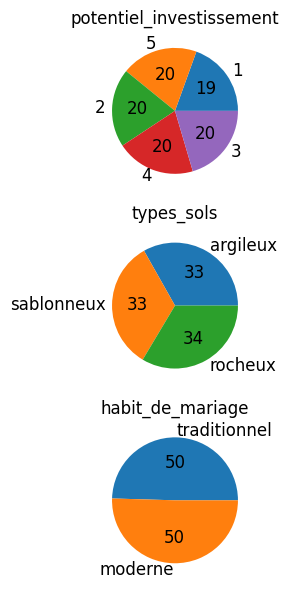

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(18, 6))

for i, c in enumerate(ss[cat_cols]):
    _ = ss[c].value_counts()[::-1].plot(kind = 'pie', ax=axes[i], title=c, autopct='%.0f', fontsize=12)
    _ = axes[i].set_ylabel('')

_ = plt.tight_layout()

In [ ]:
cat_cols_with_country = ['country', 'potentiel_investissement',
 'types_sols',
 'habit_de_mariage']

features= [c for c in ss.columns if c not in TARGET_COL]

num_cols = [c for c in features if c not in cat_cols_with_country]
num_cols

['lat',
 'lon',
 'population',
 'taux_ensoleillement',
 'demande_energetique_actuelle',
 'capacite_installee_actuelle',
 'duree_ensoleillement_annuel',
 'cout_installation_solaire',
 'proximite_infrastructures_energetiques',
 'taux_adoption_energies_renouvelables',
 'stabilite_politique',
 'taux_acces_energie',
 'niveau_urbanisation',
 'emissions_co2_evitees',
 'idh',
 'nombre_animaux_domestiques']

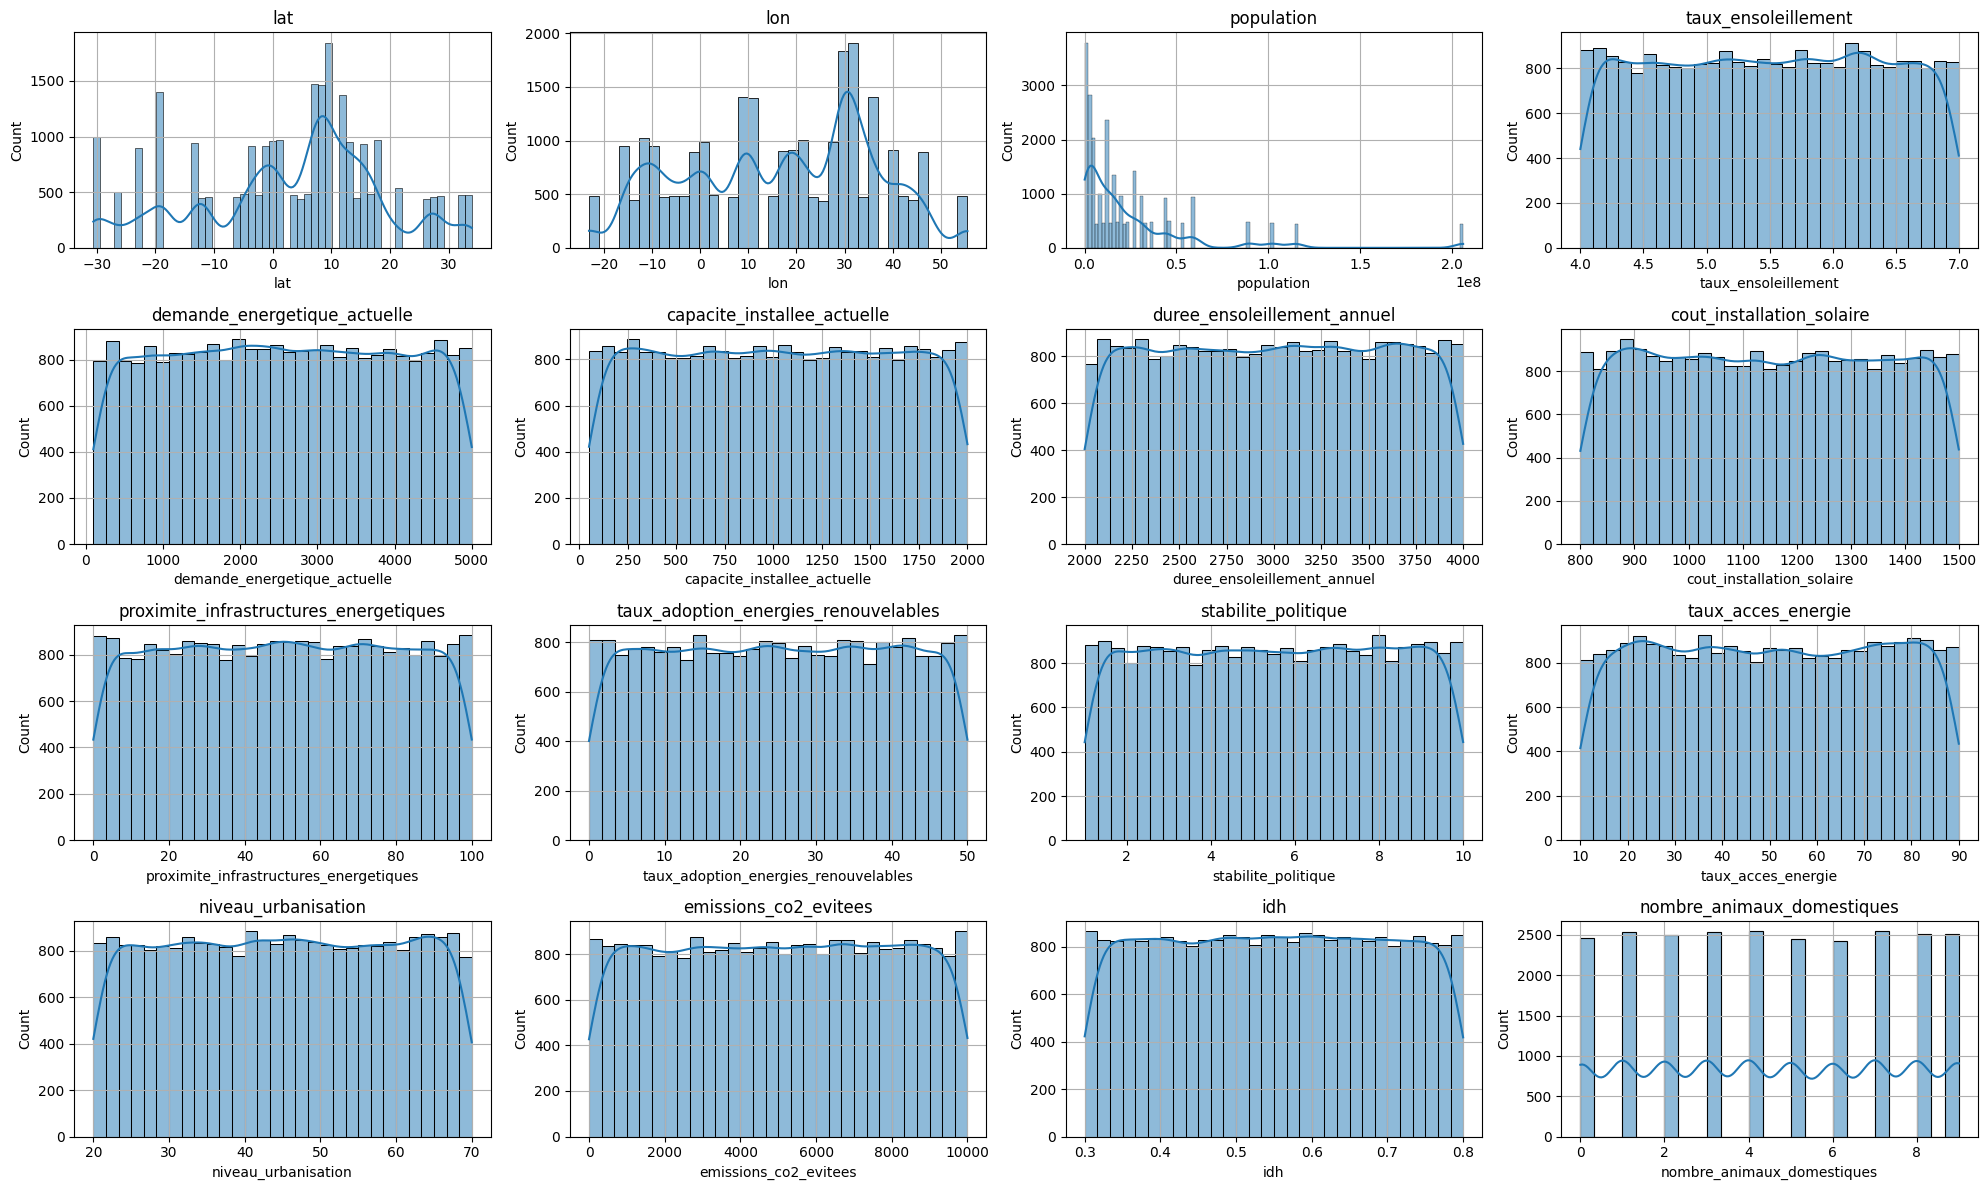

In [ ]:
fig, axes = plt.subplots(4, 4, figsize= (20, 12))
axes = axes.flatten()

# Plot each variable
for i, predictor in enumerate(num_cols):
    sns.histplot(ss[predictor], kde=True, ax=axes[i])
    axes[i].set_title(predictor)

# Adjust layout
plt.tight_layout()
plt.show()

In [48]:
# Label Encoding
le = LabelEncoder()
ss['habit_de_mariage'] = le.fit_transform(ss['habit_de_mariage'])

In [49]:
ss.head(2)

,country,lat,lon,population,taux_ensoleillement,demande_energetique_actuelle,capacite_installee_actuelle,duree_ensoleillement_annuel,cout_installation_solaire,proximite_infrastructures_energetiques,taux_adoption_energies_renouvelables,stabilite_politique,taux_acces_energie,niveau_urbanisation,potentiel_investissement,types_sols,emissions_co2_evitees,idh,habit_de_mariage,nombre_animaux_domestiques
0,Sierra Leone,8.4606,-11.7799,7976983,6.016310,2288.205830,1506.365949,3856.453895,1453.281847,56.433841,25.196118,9.187338,35.022992,58.938006,2,sablonneux,9432.861305,0.722109,1,3
1,Sierra Leone,8.4606,-11.7799,7976983,6.410925,2402.680846,1878.297944,3652.332264,1076.560589,46.100498,27.037202,5.307233,52.154399,58.293952,4,argileux,7466.567405,0.518997,1,3


In [50]:
#We'll use one-hot-encoding on the "types_sols" and "potentiel_investissement" columns
one_hot_cols = ['types_sols', 'potentiel_investissement']
ss = pd.get_dummies(ss, columns = one_hot_cols)

In [ ]:
ss.head(2)

,country,lat,lon,population,taux_ensoleillement,demande_energetique_actuelle,capacite_installee_actuelle,duree_ensoleillement_annuel,cout_installation_solaire,proximite_infrastructures_energetiques,...,habit_de_mariage,nombre_animaux_domestiques,types_sols_argileux,types_sols_rocheux,types_sols_sablonneux,potentiel_investissement_1,potentiel_investissement_2,potentiel_investissement_3,potentiel_investissement_4,potentiel_investissement_5
0,Sierra Leone,8.4606,-11.7799,7976983,6.016310,2288.205830,1506.365949,3856.453895,1453.281847,56.433841,...,traditionnel,3,False,False,True,False,True,False,False,False
1,Sierra Leone,8.4606,-11.7799,7976983,6.410925,2402.680846,1878.297944,3652.332264,1076.560589,46.100498,...,traditionnel,3,True,False,False,False,False,False,True,False


In [ ]:
df.head(2)

,population,taux_ensoleillement,demande_energetique_actuelle,demande_energetique_projectee,capacite_installee_actuelle,duree_ensoleillement_annuel,cout_installation_solaire,proximite_infrastructures_energetiques,taux_adoption_energies_renouvelables,stabilite_politique,...,types_sols_argileux,types_sols_rocheux,types_sols_sablonneux,potentiel_investissement_1,potentiel_investissement_2,potentiel_investissement_3,potentiel_investissement_4,potentiel_investissement_5,country_encoded,geo_cluster
0,0.135399,-0.557971,-1.566858,-1.696891,-0.718164,1.580581,-1.105417,-1.197860,-0.729597,-1.131630,...,False,True,False,False,False,False,True,False,3908.186051,10
1,-0.505317,-1.025902,-0.729844,-0.814789,-1.671541,1.284225,-1.443186,-1.964477,1.158518,-1.056627,...,False,False,True,False,True,False,False,False,3910.324001,6


In [51]:
ss['country_encoded'] = ss['country'].map(target_mean)


In [52]:
ss.head(2)

,country,lat,lon,population,taux_ensoleillement,demande_energetique_actuelle,capacite_installee_actuelle,duree_ensoleillement_annuel,cout_installation_solaire,proximite_infrastructures_energetiques,...,nombre_animaux_domestiques,types_sols_argileux,types_sols_rocheux,types_sols_sablonneux,potentiel_investissement_1,potentiel_investissement_2,potentiel_investissement_3,potentiel_investissement_4,potentiel_investissement_5,country_encoded
0,Sierra Leone,8.4606,-11.7799,7976983,6.016310,2288.205830,1506.365949,3856.453895,1453.281847,56.433841,...,3,False,False,True,False,True,False,False,False,3842.803123
1,Sierra Leone,8.4606,-11.7799,7976983,6.410925,2402.680846,1878.297944,3652.332264,1076.560589,46.100498,...,3,True,False,False,False,False,False,True,False,3842.803123


Since we've encoded the country column (country_encoded), we can drop the original feature

In [53]:
ss.drop('country', axis=1)

,lat,lon,population,taux_ensoleillement,demande_energetique_actuelle,capacite_installee_actuelle,duree_ensoleillement_annuel,cout_installation_solaire,proximite_infrastructures_energetiques,taux_adoption_energies_renouvelables,...,nombre_animaux_domestiques,types_sols_argileux,types_sols_rocheux,types_sols_sablonneux,potentiel_investissement_1,potentiel_investissement_2,potentiel_investissement_3,potentiel_investissement_4,potentiel_investissement_5,country_encoded
0,8.4606,-11.7799,7976983,6.016310,2288.205830,1506.365949,3856.453895,1453.281847,56.433841,25.196118,...,3,False,False,True,False,True,False,False,False,3842.803123
1,8.4606,-11.7799,7976983,6.410925,2402.680846,1878.297944,3652.332264,1076.560589,46.100498,27.037202,...,3,True,False,False,False,False,False,True,False,3842.803123
2,6.8769,31.3069,11193725,4.642565,3996.471566,344.400305,3810.507756,980.596863,88.583926,47.880078,...,9,False,False,True,False,True,False,False,False,3862.714525
3,-18.6657,35.5296,31255435,5.704522,3134.406856,1614.664206,3319.984749,1373.043279,45.876645,40.282065,...,9,False,False,True,False,False,True,False,False,3882.049424
4,-19.0154,29.1549,14862924,6.581508,2560.551232,1151.776893,2829.581194,895.661665,91.039562,10.630429,...,6,False,True,False,False,False,False,False,True,3908.186051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,-19.0154,29.1549,14862924,6.478351,4668.906579,1682.285214,2416.010087,1293.327007,9.071036,18.204734,...,7,False,False,True,False,False,True,False,False,3908.186051
24996,14.4974,-14.4524,16743927,4.172322,4790.888011,483.548704,2490.983578,1251.153249,88.832616,19.211432,...,3,False,False,True,True,False,False,False,False,3882.230072
24997,12.8628,30.2176,43849260,4.927053,2840.640220,260.516323,3196.271094,873.141147,72.079660,27.712440,...,5,True,False,False,False,False,True,False,False,3971.795977
24998,1.3733,32.2903,45741007,5.332028,2383.927811,1689.060842,3615.998294,1294.781590,83.041109,26.731811,...,7,True,False,False,False,False,True,False,False,3867.490962


In [54]:
country_means = ss.groupby('country_encoded')['taux_adoption_energies_renouvelables'].transform('mean')

# Fill NaN values with the mean of the respective country

ss['taux_adoption_energies_renouvelables'] = ss['taux_adoption_energies_renouvelables'].fillna(country_means)

ss.isnull().sum()

,0
country,0
lat,0
lon,0
population,0
taux_ensoleillement,0
demande_energetique_actuelle,0
capacite_installee_actuelle,0
duree_ensoleillement_annuel,0
cout_installation_solaire,0
proximite_infrastructures_energetiques,0


In [55]:
ss = ss.drop('country', axis=1)

In [56]:
ss.columns

Index(['lat', 'lon', 'population', 'taux_ensoleillement',
       'demande_energetique_actuelle', 'capacite_installee_actuelle',
       'duree_ensoleillement_annuel', 'cout_installation_solaire',
       'proximite_infrastructures_energetiques',
       'taux_adoption_energies_renouvelables', 'stabilite_politique',
       'taux_acces_energie', 'niveau_urbanisation', 'emissions_co2_evitees',
       'idh', 'habit_de_mariage', 'nombre_animaux_domestiques',
       'types_sols_argileux', 'types_sols_rocheux', 'types_sols_sablonneux',
       'potentiel_investissement_1', 'potentiel_investissement_2',
       'potentiel_investissement_3', 'potentiel_investissement_4',
       'potentiel_investissement_5', 'country_encoded'],
      dtype='object')

In [ ]:
ss_features = ss.columns

In [57]:
# Number of clusters
num_clusters = 14

# Prepare data for clustering
geo_data = ss[['lat', 'lon']]

# Apply KMeans clustering
kmeans = KMeans(n_clusters=14, random_state=1)
ss['geo_cluster'] = kmeans.fit_predict(geo_data)

In [58]:
# Replace latitude and longitude with cluster IDs
ss = ss.drop(['lat', 'lon'], axis=1)

In [ ]:
# Identify numerical and categorical columns
cat_cols = ['country', 'habit_de_mariage', 'types_sols_argileux', 'types_sols_rocheux', 'types_sols_sablonneux', 'potentiel_investissement_1', 'potentiel_investissement_2', 'potentiel_investissement_3', 'potentiel_investissement_4', 'potentiel_investissement_5', 'country_encoded' ,'geo_cluster']
num_cols = [c for c in ss.columns if c not in cat_cols]

In [ ]:
num_cols

['population',
 'taux_ensoleillement',
 'demande_energetique_actuelle',
 'capacite_installee_actuelle',
 'duree_ensoleillement_annuel',
 'cout_installation_solaire',
 'proximite_infrastructures_energetiques',
 'taux_adoption_energies_renouvelables',
 'stabilite_politique',
 'taux_acces_energie',
 'niveau_urbanisation',
 'emissions_co2_evitees',
 'idh',
 'nombre_animaux_domestiques']

In [ ]:
ss.columns

Index(['population', 'taux_ensoleillement', 'demande_energetique_actuelle',
       'capacite_installee_actuelle', 'duree_ensoleillement_annuel',
       'cout_installation_solaire', 'proximite_infrastructures_energetiques',
       'taux_adoption_energies_renouvelables', 'stabilite_politique',
       'taux_acces_energie', 'niveau_urbanisation', 'emissions_co2_evitees',
       'idh', 'habit_de_mariage', 'nombre_animaux_domestiques',
       'types_sols_argileux', 'types_sols_rocheux', 'types_sols_sablonneux',
       'potentiel_investissement_1', 'potentiel_investissement_2',
       'potentiel_investissement_3', 'potentiel_investissement_4',
       'potentiel_investissement_5', 'country_encoded', 'geo_cluster'],
      dtype='object')

In [59]:
num_cols

['population',
 'taux_ensoleillement',
 'demande_energetique_actuelle',
 'capacite_installee_actuelle',
 'duree_ensoleillement_annuel',
 'cout_installation_solaire',
 'proximite_infrastructures_energetiques',
 'taux_adoption_energies_renouvelables',
 'stabilite_politique',
 'taux_acces_energie',
 'niveau_urbanisation',
 'emissions_co2_evitees',
 'idh',
 'nombre_animaux_domestiques']

In [60]:
# Apply Yeo-Johnson transformation to numerical features
pt = PowerTransformer(method='yeo-johnson')
ss[num_cols] = pt.fit_transform(ss[num_cols])

ss.head()

,population,taux_ensoleillement,demande_energetique_actuelle,capacite_installee_actuelle,duree_ensoleillement_annuel,cout_installation_solaire,proximite_infrastructures_energetiques,taux_adoption_energies_renouvelables,stabilite_politique,taux_acces_energie,...,types_sols_argileux,types_sols_rocheux,types_sols_sablonneux,potentiel_investissement_1,potentiel_investissement_2,potentiel_investissement_3,potentiel_investissement_4,potentiel_investissement_5,country_encoded,geo_cluster
0,-0.266718,0.608792,-0.098076,0.854465,1.448415,1.468272,0.296643,0.077762,1.354521,-0.599837,...,False,False,True,False,True,False,False,False,3842.803123,1
1,-0.266718,1.052356,-0.018957,1.400817,1.114047,-0.330873,-0.039617,0.205397,-0.024498,0.148483,...,True,False,False,False,False,False,True,False,3842.803123,1
2,-0.045955,-0.981631,0.998031,-1.215210,1.373512,-0.817684,1.251126,1.548214,-1.635546,1.214950,...,False,False,True,False,True,False,False,False,3862.714525,5
3,0.701259,0.254405,0.465200,1.017043,0.560277,1.098035,-0.047114,1.076897,0.018217,-0.045334,...,False,False,True,False,False,True,False,False,3882.049424,7
4,0.148225,1.242463,0.088515,0.297524,-0.280843,-1.260526,1.319707,-1.022586,-0.725716,1.057780,...,False,True,False,False,False,False,False,True,3908.186051,7


In [63]:
# Using the previously trained model to make predictions
lgb_oofs, lgb_preds = run_reg_kfold(best_model, train_proc, ss, features, num_cols, TARGET_COL)


------------- Fold 1 -------------
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3209
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 25
[LightGBM] [Info] Start training from score 3892.906280
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [64]:
# Create the submission DataFrame with predictions
submission_df = pd.DataFrame({
    'ID': range(1, len(lgb_preds) + 1),  # Create an ID column starting at 1
    'Prediction': lgb_preds             # Predictions from the trained model
})

print(submission_df.head())



   ID   Prediction
0   1  3499.211579
1   2  3640.970622
2   3  6084.956234
3   4  4807.231239
4   5  3893.651388


In [65]:
# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)
